# Dog VS Cat using Transfer Learning 正式版

In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.applications import ResNet50, VGG16, InceptionV3
from keras.applications.vgg16 import preprocess_input, decode_predictions
# from utils import make_parallel
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from keras.utils import to_categorical
from tqdm import tqdm
%matplotlib inline

Using TensorFlow backend.


# 1. 将预训练模型直接用于新数据预测（Inference）

### 两种情况

- **情况1：新图像内容类型从属于模型原训练集**。即模型之前见过同类图片，但图像细节不一定相同。


- **情况2：新图像内容类型不属于模型原训练集**。即模型从未见过该图像内容类型。

In [2]:
model1 = VGG16(weights='imagenet', include_top=True)

### 基本处理流程

- 导入图片：cv2.imread
- 调整尺寸：cv2.resize
- 调整维度：np.expand_dims
- 预处理（VGG采用减中值方式）：preprocess_input
- 预测：model.predict
- 解码类型：decode_predictions

### 1.1 给模型看之前看过的同类照片

- 从下面的测试结果可以看到，虽然模型之前并没有看过这些图，但是这些图所表达的图像类别（“猫“），模型是看过很多的，因此即使图片中的主体具有各种姿态、角度，甚至被遮挡，模型依然能够做出比较准确的预测。

- 同时也可以发现，预处理这一步的效果并不总是正向的。对比使用预处理前后的判断概率，第一张图的概率从 65% 降到了 16%。于此同时，第三张图却从 71% 升到了 99%。可谓功过相抵。

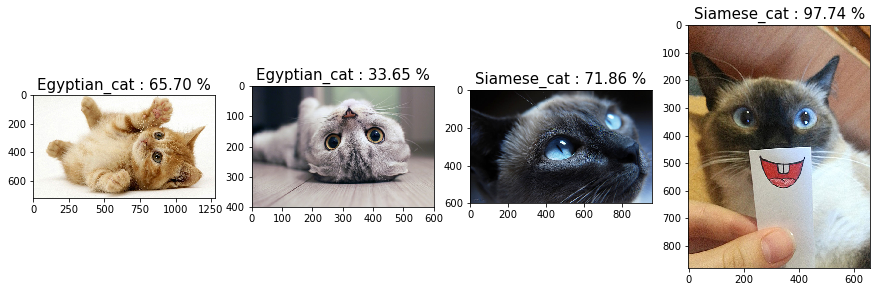

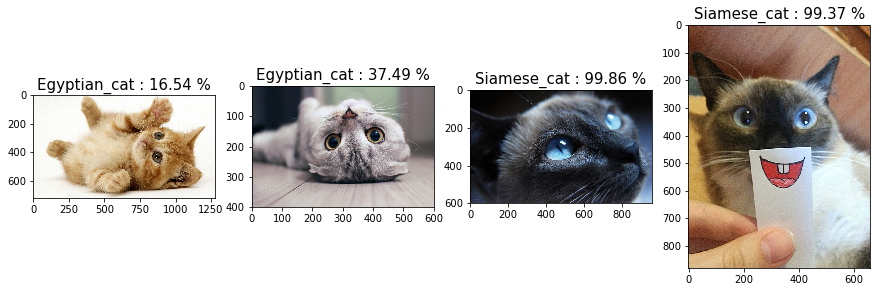

In [3]:
def inference(files, preprocess=True):
    plt.figure(figsize=(15, 7))
    for i in range(len(files)):
        plt.subplot(1, len(files), i+1)
        img = cv2.imread(files[i])
        img = img[:, :, ::-1]
        x = cv2.resize(img, dsize=(224, 224))
        x = np.expand_dims(x, axis=0)
        x = x.astype(np.float64)
        if preprocess:
            x = preprocess_input(x)
        y_pred = model1.predict(x)
        _, label, prob = decode_predictions(y_pred, top=1)[0][0]
        plt.imshow(img, cmap='gray')
        plt.title('%s : %.2f %%' % (label, prob * 100), size=15)
    plt.show()

inference(['cat1.jpg', 'cat2.jpg', 'cat3.jpg', 'cat4.jpg'], False)
inference(['cat1.jpg', 'cat2.jpg', 'cat3.jpg', 'cat4.jpg'])

### 1.2 给模型看从未看过的图片内容类型

- 从下面的测试可以看到，虽然加菲猫也是一种猫，但是它显然与上面所展示的猫的品种处于不同维度。由于模型从未看过这类内容的图片，也从未被告知这类图片的对应类型就叫做 `garfield`，因此模型不可能做出准确的预测。

- 不过我们同时也能看到，虽然模型不知道加菲猫这个词，但是有幸识别出 `comic_book` 这个类型，也算是一种成功。

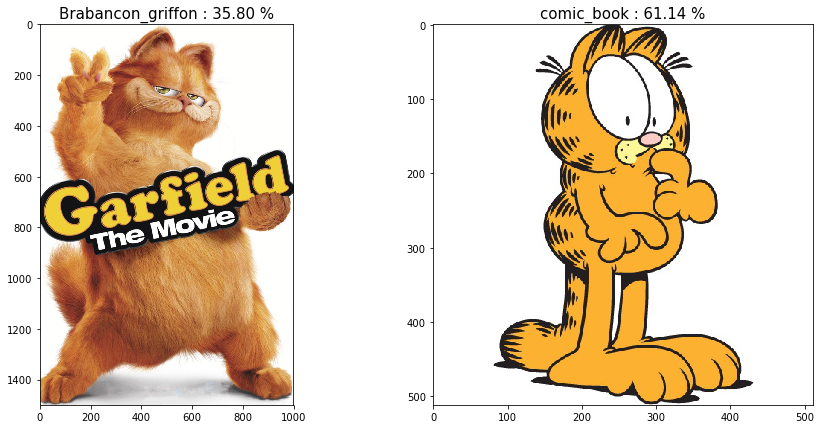

In [4]:
inference(['cat5.jpg', 'cat6.jpg'])

# 2. 将预训练模型搭配新分类器 在新数据集上训练该分类器 (Transfer Learning)

### 两种方式

- **方式1：载入预训练的整个模型结构 + 权重**，搭配新分类器训练


- **方式2：**构建与预训练模型结构一致的模型，**仅载入预训练的权重**，搭配新分类器训练

### 2.0 数据准备

#### 基本处理流程

- 读入每张图片：cv2.imread
- 调整图片尺寸：cv2.resize
- 定义图片对应的类别：cat = 0, dog = 1
- 同步打乱图片和分类顺序：shuffle
- 分割为训练集和验证集：train_test_split （可以省略，后面训练时可以通过配置validation_split参数达到同样目的）

In [10]:
shape = 299
label = np.array([0] * 12500 + [1] * 12500)
data = np.zeros((25000, shape, shape, 3), dtype=np.uint8)

for i in tqdm(range(12500)):
    img = cv2.imread('./train/cat/%s.jpg' % str(i))
    img = img[:, :, ::-1]
    data[i] = cv2.resize(img, (shape, shape))
    
for i in tqdm(range(12500)):
    img = cv2.imread('./train/dog/%s.jpg' % str(i))
    img = img[:, :, ::-1]
    data[i + 12500] = cv2.resize(img, (shape, shape))
    
print('Training Data Size = %.2f GB' % (sys.getsizeof(data)/1024**3))

100%|█████████████████████████████████████████████████████| 12500/12500 [00:30<00:00, 406.45it/s]


Training Data Size = 6.24 GB


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data, label, shuffle=True, test_size=0.2, random_state=42)

In [14]:
test = np.zeros((12500, shape, shape, 3), dtype=np.uint8)
for i in tqdm(range(12500)):
    img = cv2.imread('./test/%s.jpg' % str(i + 1))
    img = img[:, :, ::-1]
    test[i] = cv2.resize(img, (shape, shape))
print('Testing Data Size = %.2f GB' % (sys.getsizeof(test)/1024**3))

100%|█████████████████████████████████████████████████████| 12500/12500 [00:30<00:00, 414.50it/s]


Testing Data Size = 3.12 GB


### 2.1 载入预训练模型及权重，训练新分类器

#### 基本流程

- **导入预训练模型及相应权重（去除分类器部分）**：XXX()
- **将预训练模型所有层锁定以避免被训练修改**：layers.trainable = False
- **给预训练模型尾部添加新的分类器**：根据分类个数选择 `sigmoid` 还是 `softmax`
- **编译预训练模型**：根据分类个数选择 `binary_crossentropy` 还是 `categorical_crossentropy`
- **查看可训练权重个数**：自定义 `get_param_count` 函数计算模型解锁参数个数
- **训练模型**
    - 应使用较小的 `batch_size` 进行训练，这样即使使用较少的训练代数依然能够收敛到很高的准确率。
    - 训练代数通常不需要太多，5-10代即可，这是因为模型目前可训练参数个数很少（这里只有500多个），因此并不需要太多代来让所有参数都达到最优值。

#### 下面我们先使用具有22层的VGG16模型进行Transfer Learning.

In [8]:
from keras import backend as K

def get_params_count(model):
    trainable = int(np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
    non_trainable = int(np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))
    return trainable, non_trainable

In [29]:
base_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False, pooling='avg')

for layers in base_model.layers:
    layers.trainable = False

y = Dropout(0.5)(base_model.output)
y = Dense(1, activation='sigmoid')(y)

model2 = Model(inputs=base_model.input, outputs=y)
model2.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model2.summary()
print('Model has %d layers.' % len(model2.layers))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [17]:
model2.fit(x=X_train, y=y_train, batch_size=16, epochs=5, validation_data=(X_val, y_val), shuffle=True)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 93s - loss: 1.2397 - acc: 0.8021 - val_loss: 0.1697 - val_acc: 0.9522
Epoch 2/5
20000/20000 [==============================] - 93s - loss: 0.3938 - acc: 0.9163 - val_loss: 0.1378 - val_acc: 0.9624
Epoch 3/5
20000/20000 [==============================] - 93s - loss: 0.2970 - acc: 0.9304 - val_loss: 0.1214 - val_acc: 0.9646
Epoch 4/5
20000/20000 [==============================] - 94s - loss: 0.2516 - acc: 0.9360 - val_loss: 0.1073 - val_acc: 0.9680
Epoch 5/5
20000/20000 [==============================] - 94s - loss: 0.2319 - acc: 0.9395 - val_loss: 0.1012 - val_acc: 0.9674


### 换个模型训练

下面我们使用含有178层的ResNet50预训练模型进行Transfer Learning

In [13]:
base_model = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False, pooling='avg')

for layers in base_model.layers:
    layers.trainable = False

y = Dropout(0.25)(base_model.output)
y = Dense(1, activation='sigmoid')(y)

model3 = Model(inputs=base_model.input, outputs=y)
model3.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model3.summary()
print('Model has %d layers.' % len(model3.layers))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D) (None, 230, 230, 3)   0           input_2[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        zero_padding2d_2[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
___________________________________________________________________________________________

In [15]:
model3.fit(x=X_train, y=y_train, batch_size=16, epochs=5, validation_data=(X_val, y_val), shuffle=True)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 109s - loss: 0.0883 - acc: 0.9658 - val_loss: 0.0560 - val_acc: 0.9782
Epoch 2/5
20000/20000 [==============================] - 110s - loss: 0.0845 - acc: 0.9671 - val_loss: 0.0556 - val_acc: 0.9782
Epoch 3/5
20000/20000 [==============================] - 110s - loss: 0.0808 - acc: 0.9691 - val_loss: 0.0586 - val_acc: 0.9758
Epoch 4/5
20000/20000 [==============================] - 110s - loss: 0.0830 - acc: 0.9685 - val_loss: 0.0525 - val_acc: 0.9786
Epoch 5/5
20000/20000 [==============================] - 110s - loss: 0.0813 - acc: 0.9677 - val_loss: 0.0529 - val_acc: 0.9782


### 使用 InceptionV3 进行迁移学习

In [17]:
from keras.applications import inception_v3, xception, resnet50, vgg16, vgg19
from keras.applications import InceptionV3, Xception, ResNet50, VGG16, VGG19
from keras.models import load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Lambda

pre = Input(shape=(299, 299, 3))
pre = Lambda(inception_v3.preprocess_input)(pre)
base_model_inception = InceptionV3(include_top=False, input_tensor=pre, weights='imagenet', pooling='avg')
for layer in base_model_inception.layers:
    layer.trainable = False
y = Dropout(0.2)(base_model_inception.output)
y = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(y)
model_inception = Model(inputs=base_model_inception.input, outputs=y, name='Transfer_Learning_Inception')
model_inception.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [18]:
from datetime import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint


log_dir = datetime.now().strftime('transfer_model_%Y%m%d_%H%M')
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

es = EarlyStopping(monitor='val_loss', patience=20)
mc = ModelCheckpoint(log_dir + '\\DogVSCat-EP{epoch:02d}-LOSS{val_loss:.4f}.h5', 
                     monitor='val_loss', save_best_only=True)

model_inception.fit(x=X_train, 
                    y=y_train, 
                    batch_size=16, 
                    epochs=10, 
                    validation_data=(X_val, y_val), 
                    callbacks=[es, mc])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 164s - loss: 0.2089 - acc: 0.9333 - val_loss: 0.0967 - val_acc: 0.9758
Epoch 2/10
20000/20000 [==============================] - 159s - loss: 0.1242 - acc: 0.9549 - val_loss: 0.0724 - val_acc: 0.9788
Epoch 3/10
20000/20000 [==============================] - 159s - loss: 0.1117 - acc: 0.9590 - val_loss: 0.0630 - val_acc: 0.9822
Epoch 4/10
20000/20000 [==============================] - 159s - loss: 0.1084 - acc: 0.9582 - val_loss: 0.0620 - val_acc: 0.9812
Epoch 5/10
20000/20000 [==============================] - 159s - loss: 0.1017 - acc: 0.9626 - val_loss: 0.0539 - val_acc: 0.9820
Epoch 6/10
  112/20000 [..............................] - ETA: 124s - loss: 0.0754 - acc: 0.9464

KeyboardInterrupt: 

### 同样使用 InceptionV3 但直接导出特征向量再训练分类器

In [20]:
pre = Input(shape=(299, 299, 3))
pre = Lambda(inception_v3.preprocess_input)(pre)
base_model_inception = InceptionV3(include_top=False, input_tensor=pre, weights='imagenet', pooling='avg')
train_gap = base_model_inception.predict(data, batch_size=128)
test_gap = base_model_inception.predict(test, batch_size=128)

X_train, X_val, y_train, y_val = train_test_split(train_gap, label, shuffle=True, test_size=0.2, random_state=42)

In [21]:
inputs = Input(shape=(X_train.shape[1],))
y = Dropout(0.2)(inputs)
y = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(y)
model_inception = Model(inputs=inputs, outputs=y, name='GAP_Inception')
model_inception.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [22]:
from datetime import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint


log_dir = datetime.now().strftime('transfer_model_%Y%m%d_%H%M')
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

es = EarlyStopping(monitor='val_loss', patience=20)
mc = ModelCheckpoint(log_dir + '\\DogVSCat-EP{epoch:02d}-LOSS{val_loss:.4f}.h5', 
                     monitor='val_loss', save_best_only=True)

model_inception.fit(x=X_train, 
                    y=y_train, 
                    batch_size=16, 
                    epochs=10, 
                    validation_data=(X_val, y_val), 
                    callbacks=[es, mc])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 5s - loss: 0.0730 - acc: 0.9859 - val_loss: 0.0318 - val_acc: 0.9910
Epoch 2/10
20000/20000 [==============================] - 4s - loss: 0.0270 - acc: 0.9927 - val_loss: 0.0266 - val_acc: 0.9918
Epoch 3/10
20000/20000 [==============================] - 4s - loss: 0.0225 - acc: 0.9936 - val_loss: 0.0243 - val_acc: 0.9920
Epoch 4/10
20000/20000 [==============================] - 4s - loss: 0.0207 - acc: 0.9935 - val_loss: 0.0236 - val_acc: 0.9922
Epoch 5/10
20000/20000 [==============================] - 3s - loss: 0.0199 - acc: 0.9936 - val_loss: 0.0231 - val_acc: 0.9930
Epoch 6/10
20000/20000 [==============================] - 4s - loss: 0.0192 - acc: 0.9940 - val_loss: 0.0226 - val_acc: 0.9928
Epoch 7/10
20000/20000 [==============================] - 3s - loss: 0.0179 - acc: 0.9944 - val_loss: 0.0230 - val_acc: 0.9926
Epoch 8/10
20000/20000 [==============================] - 4s -

#### 用 Validation Loss = 0.0222 的模型，可以在Kaggle的测试集上达到 0.03981 (15名) 的样子。

In [23]:
y_pred = model_inception.predict(test_gap)
y_pred = y_pred.clip(min=0.005, max=0.995)

In [24]:
with open('test.csv', 'w') as f:
    f.writelines('id,label\n')
    for i in range(12500):
        f.writelines(str(i+1) + ',' + str(y_pred[i][0]) + '\n')

### 2.2 构建与预训练模型结构一致的模型，仅载入预训练的权重，搭配新分类器训练

- 这种方案显然没有第一种方案简单，因为需要自己手动搭出一个完整的模型，然后再导入预训练模型的权重后才能使用。
- 这种方案要求你能够搭出和预训练模型结构完全一致（所有权重矩阵的尺寸都相同）的模型，否则在 load_weights 的时候就会报错。这种方案主要的好处是自己构建的模型其实可以和预训练模型有所出入，比如输入尺寸、各层的超参配置等。对于图片大小比较小的数据集（例如 CIFAR10），由于图片尺寸根本没达到预训练模型要求的下限，因此没法直接定义 `VGG16(input_shape=(32, 32, 3))`。要不然放大所有图片，要不然就是这种方案。

In [22]:
x = Input(shape=(32, 32, 3))
y = x
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Convolution2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = Convolution2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = Convolution2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

y = GlobalAveragePooling2D()(y)
# y = Dropout(0.5)(y)
# y = Dense(10, activation='softmax')(y)

modelx = Model(inputs=x, outputs=y)

In [23]:
modelx.load_weights('C:\\Users\\Michael\\.keras\\models\\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')
modelx.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
__________

In [24]:
modelx.layers

In [25]:
[weights, bias] = modelx.layers[1].get_weights()
print(weights.shape)
print(bias.shape)

(3, 3, 3, 64)
(64,)


In [26]:
weights[:, :, :, 0]

array([[[ 0.42947057,  0.55037946,  0.4800154 ],
        [ 0.373467  ,  0.44007453,  0.4085474 ],
        [-0.06136011, -0.08138704, -0.06514555]],

       [[ 0.27476987,  0.34573907,  0.31047726],
        [ 0.03868078,  0.04063221,  0.05020237],
        [-0.36722335, -0.45350131, -0.40338343]],

       [[-0.05746817, -0.05863491, -0.05087169],
        [-0.26224968, -0.33066967, -0.28522751],
        [-0.35009676, -0.4850302 , -0.41851634]]], dtype=float32)

In [27]:
bias[0]

0.73429835

## 3. 将预训练模型搭配训练好的分类器，在新数据集上微调预训练模型最后几层 (Fine-tuning)

#### 基本流程

- 选定模型中较靠后的部分解冻，参与训练
- 由于模型中通常都是串联的几层搭配组合，一般建议属于一个组合的层最好同时冻结或解冻。
- **关于如何选择解锁层的数量**：从高（输出端）往低（输入端）一部分一部分的解锁，每解锁一部分，就训练5轮，看看模型的Loss和准确率是否有改善的趋势，如果有就继续训练，如果没有，就接着解锁上一部分，直至模型训练出现改善。

In [33]:
model3.layers[-37:]

In [39]:
for layers in model3.layers[-35:]:
    layers.trainable = True
    
print('Trainable = %d, Non-Trainable = %d' % (get_params_count(model3)))

Trainable = 14453249, Non-Trainable = 9136512


In [40]:
model3.fit(x=X_train, y=y_train, batch_size=16, epochs=10, validation_data=(X_val, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 110s - loss: 0.0772 - acc: 0.9705 - val_loss: 0.0500 - val_acc: 0.9798
Epoch 2/5
20000/20000 [==============================] - 109s - loss: 0.0794 - acc: 0.9694 - val_loss: 0.0511 - val_acc: 0.9786
Epoch 3/5
20000/20000 [==============================] - 110s - loss: 0.0749 - acc: 0.9692 - val_loss: 0.0497 - val_acc: 0.9810
Epoch 4/5
20000/20000 [==============================] - 110s - loss: 0.0709 - acc: 0.9722 - val_loss: 0.0516 - val_acc: 0.9796
Epoch 5/5
20000/20000 [==============================] - 110s - loss: 0.0765 - acc: 0.9694 - val_loss: 0.0503 - val_acc: 0.9798


In [10]:
model3.save('ResNet_Finetune_last3_epoch5.h5')

#### 比较郁闷的是，即使将模型的倒数35层权重全都解锁，模型的Fine-Tune效果依然并不明显。

## 4. 多模型融合

#### 基本流程

- 计算特征向量：计算出每个模型对整个训练集的输出值（去除分类器部分）
- 合并特征向量：将多个模型计算得到的特征向量合并
- 训练分类器
- 预测

#### 为什么叫特征向量

- 其实去除分类器的预训练模型原本的输出应该是一堆特征图，但是由于我们加上了Global Average Pooling，以取代全连接层的Flatten，因此最后得到的实际上就是一个一维向量，由于它包含着模型对于图像的特征识别情况，因此我们就管它叫特征向量。


- 当我们拿到特征向量的时候，**我们就已经和CNN拜拜了**，剩下的任务和任何监督学习的任务一样，就是输入特征向量，然后训练分类器，对这些特征进行分类而已。


#### 导出的特征向量是什么尺寸？

- 由于使用了Global Average Pooling，因此对于一个图像样本，模型输出的是具有 2048 个特征的向量。
- 因此对于整个训练集来说，导出的特征向量尺寸是 (25000, 2048)

### 4.1 计算模型特征向量 - 生成器方案

- 需要先定义**基于文件的生成器**（flow_from_directory），然后再用专门的**生成器预测函数**（predict_generator）计算特征向量。
- 由于是从硬盘一批一批的将文件读进来，因此速度很慢，光VGG16就用了20多分钟。

In [ ]:
import h5py
def export_gap(MODEL, image_size, preprocess=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if preprocess:
        x = Lambda(preprocess)(x)
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    y = GlobalAveragePooling2D()(base_model.output)
    model = Model(base_model.input, y)

    # 不做图像增强，仅仅作为生成器使用
    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("train", image_size, shuffle=False, batch_size=16, 
                                              classes=['cat', 'dog'])
    test_generator = gen.flow_from_directory("test", image_size, shuffle=False, batch_size=16, 
                                             class_mode=None)

    train = model.predict_generator(train_generator, train_generator.samples)
    test = model.predict_generator(test_generator, test_generator.samples)
    with h5py.File("gap_%s.h5" % MODEL.__name__, 'w') as f:
        f.create_dataset("train", data=train)
        f.create_dataset("test", data=test)
        f.create_dataset("label", data=train_generator.classes)
        
export_gap(VGG16, (224, 224))

### 4.2 计算模型特征向量 - 内存方案

- 由于在之前已经把猫狗大战的训练集和测试集全部数据都读入内存了，因此可以直接用 model.predict 来获得特征向量。
- 这样速度要快的多。基本上2分钟就可以导出一个预训练模型的训练集和测试集特征向量。

In [104]:
import h5py
from keras.applications import inception_v3, xception, VGG19, Xception
from keras.layers import Lambda

def export_gap(MODEL, preprocess=None):
    x = Input((224, 224, 3))
    if preprocess:
        x = Lambda(preprocess)(x)
    model = MODEL(input_tensor=x, weights='imagenet', include_top=False, pooling='avg')

    train_gap = model.predict(data, batch_size=128)
    test_gap = model.predict(test, batch_size=128)
    
    with h5py.File("gap_%s.h5" % MODEL.__name__, 'w') as f:
        f.create_dataset('train', data=train_gap)
        f.create_dataset('test', data=test_gap)

In [93]:
export_gap(InceptionV3, preprocess=inception_v3.preprocess_input)

In [99]:
export_gap(Xception, preprocess=xception.preprocess_input)

In [105]:
export_gap(VGG16)

In [95]:
export_gap(VGG19)

In [98]:
export_gap(ResNet50)

### 4.3 合并（串联）来自不同模型的特征向量

- 使用 `np.concatenate` 在指定维度上串联
- 原本我一直以为模型融合的”融合“会涉及到某种形式上的平均或者加权，实际上这里所做的”融合“仅仅是将特征向量串联起来而已。毕竟实际情况下要融合的多个模型输出的特征向量并不一定都是这里的2048个，而且不同模型识别出来的特征向量本身并没有什么顺序可言，因此强制加权将这些特征向量缩减是没有道理的，正确的做法应该是把全部的特征向量都给分类器，让分类器按照梯度下降的指引自动适配权重。

In [122]:
train = []
test = []
for gapfile in ['gap_InceptionV3.h5', 'gap_ResNet50.h5', 'gap_Xception.h5']:
    with h5py.File(gapfile, 'r') as f:
        train.append(np.array(f['train']))
        test.append(np.array(f['test']))
        
print('Feature Vector Shape for Model #0:', train[0].shape)

Feature Vector Shape for Model #0: (25000, 2048)


In [124]:
X_train = np.concatenate(train, axis=1)
X_test = np.concatenate(test, axis=1)
print('Feature Vector Shape after Merging all 3 models:', X_train.shape)

Feature Vector Shape after Merging all 3 models: (25000, 6144)


In [125]:
X_train, X_val, y_train, y_val = train_test_split(X_train, label, shuffle=True, test_size=0.2, random_state=42)

### 4.4 建立模型（分类器）

- 这里我们只需要定义一个简单的分类器即可，用于对特征向量进行分类，最后输出 0(cat) 或者 1(dog)。
- 需要清楚的是，这个模型的输入就是之前我们折腾半天得到的三个模型特征向量的合并输出，因此输入尺寸应该是 `(None, 2048*3)`

In [133]:
inputs = Input((X_train.shape[1],))
x = inputs
x = Dropout(0.25)(x)
y = Dense(1, activation='sigmoid')(x)

model_fusion = Model(inputs=inputs, outputs=y, name='Fusion')
model_fusion.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model_fusion.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 6144)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 6144)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 6145      
Total params: 6,145
Trainable params: 6,145
Non-trainable params: 0
_________________________________________________________________


### 4.5 训练模型

- 由于模型一共才6000多个参数，而且结构巨简单，因此训练10代只用了10秒钟。简直要起飞。

In [134]:
model_fusion.fit(x=X_train, y=y_train, batch_size=128, epochs=10, validation_data=(X_val, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s - loss: 0.1069 - acc: 0.9664 - val_loss: 0.0377 - val_acc: 0.9868
Epoch 2/10
20000/20000 [==============================] - 1s - loss: 0.0323 - acc: 0.9889 - val_loss: 0.0262 - val_acc: 0.9906
Epoch 3/10
20000/20000 [==============================] - 1s - loss: 0.0248 - acc: 0.9912 - val_loss: 0.0245 - val_acc: 0.9914
Epoch 4/10
20000/20000 [==============================] - 1s - loss: 0.0217 - acc: 0.9926 - val_loss: 0.0239 - val_acc: 0.9916
Epoch 5/10
20000/20000 [==============================] - 1s - loss: 0.0191 - acc: 0.9931 - val_loss: 0.0261 - val_acc: 0.9904
Epoch 6/10
20000/20000 [==============================] - 1s - loss: 0.0179 - acc: 0.9937 - val_loss: 0.0278 - val_acc: 0.9898
Epoch 7/10
20000/20000 [==============================] - 1s - loss: 0.0168 - acc: 0.9940 - val_loss: 0.0245 - val_acc: 0.9916
Epoch 8/10
20000/20000 [==============================] - 1s -

### 4.6 对测试集进行预测并上传Kaggle

- 理想情况下我们对类型的预测应该是互斥的（非0既1），即是猫就是100%猫，是狗就是100%狗。
- 但是，由于猫狗大战比赛的评判标准是**对数损失**（可以理解为 **交叉熵** 或者 **负对数似然**），公式如下：

$$\mathrm{Stochastic ~ Log ~ Loss} = - \sum_i^K y_i \cdot \log \hat{y_i}= - \big[y_0 \cdot \log \hat{y_0} + y_1 \cdot \log \hat{y_1}\big] \quad (i ~ is ~ \mathbf{Category ~ Index})$$

$$\mathrm{Average ~ Log ~ Loss} = \frac{1}{N} \sum_i^N \mathrm{Log ~ Loss}~(i)  \quad (i ~ is ~ \mathbf{Sample ~Index})$$

- **计算举例**

    - 已知 $\log 1 = 0, \log 0 = -\infty$

    - 假设图片类别为猫，即 $y_0 = 1, y_1 = 0$
    
    - 情况1：预测正确。即 $\hat{y_0} = 1, \hat{y_1} = 0$。那么得分为 0
    
    - 情况2：预测错误。即 $\hat{y_0} = 0, \hat{y_1} = 1$。那么得分为 $+\infty$

    - Kaggle 的评分系统会自动将概率值调整到 $(10^{-15}, 1 - 10^{-15})$ 这个范围内，这样如果遇到上面这种情况，得分变为34.5
    
    - 对数曲线的斜率随着自变量的增加不断减小，取值在0附近，即使是微小的变化，都能导致结果剧烈变化，而取值在1附近则几乎没有什么影响
    
        - $\log 10^{-15} = -34.5, ~\log 0.005 = -5.2$ 
        - $\log (1-10^{-15}) = -9 * e^{-16}, ~\log 0.005 = -0.005$ 

    - 因此，在同时考虑在0和1附近的取值情况下，将我们的概率输出从0/1变为0.005和0.995能够有效的降低对数损失值。

In [147]:
y_pred = model_fusion.predict(X_test)
y_pred = y_pred.clip(min=0.005, max=0.995)

11904/12500 [===========================>..] - ETA: 0s

In [145]:
y_pred.shape, y_pred[0]

((12500, 1), array([ 0.99000001], dtype=float32))

In [148]:
with open('test.csv', 'w') as f:
    f.writelines('id,label\n')
    for i in range(12500):
        f.writelines(str(i+1) + ',' + str(y_pred[i][0]) + '\n')

## 5. 图像增强

效果并不好。

In [8]:
aug = ImageDataGenerator(width_shift_range = 0.125, height_shift_range = 0.125, horizontal_flip = True)
aug.fit(X_train)
batch_size = 16
gen = aug.flow(X_train, y_train, batch_size=batch_size)
h = model3.fit_generator(generator=gen, 
                         steps_per_epoch=50000/batch_size, 
                         epochs=5, 
                         validation_data=(X_val, y_val))

Epoch 1/5
3125/3125 [==============================] - 315s - loss: 0.1061 - acc: 0.9582 - val_loss: 0.0539 - val_acc: 0.9796
Epoch 2/5
3125/3125 [==============================] - 313s - loss: 0.1033 - acc: 0.9598 - val_loss: 0.0537 - val_acc: 0.9794
Epoch 3/5
3125/3125 [==============================] - 315s - loss: 0.1043 - acc: 0.9610 - val_loss: 0.0533 - val_acc: 0.9806
Epoch 4/5
3125/3125 [==============================] - 315s - loss: 0.1019 - acc: 0.9603 - val_loss: 0.0563 - val_acc: 0.9780
Epoch 5/5
3125/3125 [==============================] - 314s - loss: 0.1003 - acc: 0.9603 - val_loss: 0.0551 - val_acc: 0.9780


## 6. 类激活图（CAM）可视化

#### 基本流程

- 对同一个图像输入，计算卷积层的输出和全连接层最后的分类输出
- data 是 

In [162]:
X_train, X_val, y_train, y_val = train_test_split(data, label, shuffle=True, test_size=0.2, random_state=42)

In [168]:
base_model = VGG16(include_top=False, weights='imagenet')
for layers in base_model.layers:
    layers.trainable = False
y = GlobalAveragePooling2D()(base_model.output)
y = Dropout(0.25)(y)
y = Dense(1, activation='sigmoid')(y)
model = Model(inputs=base_model.input, outputs=y)
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

#### 首先让我们只对模型的分类器部分训练一代，准确率达到95%

In [ ]:
model.fit(x=X_train, y=y_train, batch_size=16, epochs=1, validation_data=(X_val, y_val))

In [203]:
model2 = Model(inputs=base_model.input, outputs=[base_model.output, model.output])
out_base, out_final = model2.predict(np.expand_dims(data[1], axis=0))

In [204]:
# get_weights 返回的是含有两个元素的list，这两个元素分别是weights和bias
weights = model.layers[-1].get_weights()[0]

In [206]:
out_base.shape, out_final.shape, weights.shape

((1, 7, 7, 512), (1, 1), (512, 1))

In [207]:
out_base = out_base.squeeze()
out_final = out_final.squeeze()
weights = weights.squeeze()

In [208]:
out_base.shape, out_final.shape, weights.shape

((7, 7, 512), (), (512,))

In [219]:
res = np.matmul(out_base, weights)
np.round(res, 0)

array([[  6.,   2.,   2.,   1.,   9.,  14.,   9.],
       [ -1., -24., -69., -61., -50.,   6., -10.],
       [ -2., -46., -98., -96., -72.,  -5., -16.],
       [ -3., -15., -80., -80., -55.,  -8.,  -9.],
       [  1., -41., -81., -84., -68., -21.,  -6.],
       [  4., -38., -63., -47., -34., -14.,  -5.],
       [  1., -27., -31., -12.,  -8.,  -9.,  -8.]], dtype=float32)

In [220]:
res = res * (out_final - 0.5)
np.round(res, 0)

array([[ -3.,  -1.,  -1.,  -1.,  -4.,  -7.,  -4.],
       [  1.,  12.,  34.,  31.,  25.,  -3.,   5.],
       [  1.,  23.,  49.,  48.,  36.,   2.,   8.],
       [  2.,   7.,  40.,  40.,  28.,   4.,   4.],
       [ -0.,  20.,  41.,  42.,  34.,  10.,   3.],
       [ -2.,  19.,  31.,  23.,  17.,   7.,   2.],
       [ -1.,  13.,  15.,   6.,   4.,   4.,   4.]], dtype=float32)

In [222]:
res_norm = (res - res.min()) / res.max()
# np.round(res_norm)
res_norm

array([[ 0.08087996,  0.11842967,  0.11601726,  0.12253606,  0.04612697,
         0.        ,  0.04907868],
       [ 0.14938767,  0.38019556,  0.83998746,  0.76272178,  0.64968425,
         0.08078901,  0.23838709],
       [ 0.16178204,  0.6057741 ,  1.13778007,  1.11859274,  0.86758304,
         0.18843417,  0.30327559],
       [ 0.17070875,  0.2867592 ,  0.95673084,  0.95200998,  0.70146406,
         0.21582122,  0.22492453],
       [ 0.13187762,  0.55310982,  0.96648121,  0.98993075,  0.8286885 ,
         0.34732378,  0.2039232 ],
       [ 0.09892436,  0.52798867,  0.77808285,  0.6134007 ,  0.48860949,
         0.28374481,  0.18721919],
       [ 0.12488286,  0.40876836,  0.45193046,  0.26152363,  0.22416721,
         0.2278474 ,  0.22046764]], dtype=float32)

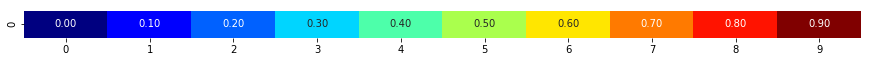

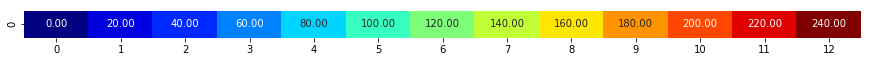

CAM Value Range: -6.8 to 49.0
CAM Value Range: 0.0 to 1.0
CAM Value Range: 0.0 to 1.0
CAM Shape:  (7, 7)
CAM Value Range: 0.0 to 254.0
CAM Shape:  (224, 224)


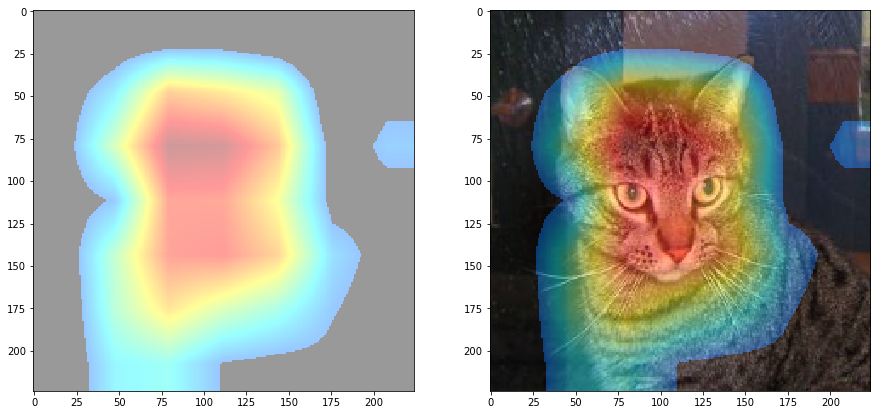

In [360]:
import seaborn as sns
plt.figure(figsize=(15, 0.5))
band = np.array([list(np.arange(0, 1, 0.1))] * 1)
sns.heatmap(band, annot=True, fmt=".2f", cmap='jet', cbar=False)
plt.show()
plt.figure(figsize=(15, 0.5))
band = np.array([list(np.arange(0, 255, 20))] * 1)
sns.heatmap(band, annot=True, fmt=".2f", cmap='jet', cbar=False)
plt.show()

plt.figure(figsize=(15, 7))
img = data[1]
x = img.copy()
out_base, out_final = model2.predict(np.expand_dims(x, axis=0))

out_final = out_final[0]
out_base = out_base[0]

if out_final < 0.5:
    plt.title('cat %.2f%%' % (100 - out_final*100))
else:
    plt.title('dog %.2f%%' % (out_final*100))

cam = (out_final - 0.5) * np.matmul(out_base, weights)
print('CAM Value Range: %.1f to %.1f' % (cam.min(), cam.max()))
# 归一化：尺度缩放以方便均匀显示颜色
cam = (cam - cam.min())/(cam.max() - cam.min())
print('CAM Value Range: %.1f to %.1f' % (cam.min(), cam.max()))
# 将分布范围略微拉长些
# cam -= 0.2
# cam /= 0.8
print('CAM Value Range: %.1f to %.1f' % (cam.min(), cam.max()))

print('CAM Shape: ', cam.shape)
cam = cv2.resize(cam, (224, 224))
cam_range = 255 * cam
cam_range = cam_range.astype(np.uint8)
print('CAM Value Range: %.1f to %.1f' % (cam_range.min(), cam_range.max()))
print('CAM Shape: ', cam.shape)

heatmap = cv2.applyColorMap(cam_range, cv2.COLORMAP_JET)
heatmap[np.where(cam_range <= 60)] = 0
heatmap = heatmap[:, :, ::-1]

plt.subplot(1, 2, 1)
plt.imshow(heatmap, alpha=0.4)
plt.subplot(1, 2, 2)
out = cv2.addWeighted(src1=img, alpha=0.8, src2=heatmap, beta=0.4, gamma=0)
plt.imshow(out)